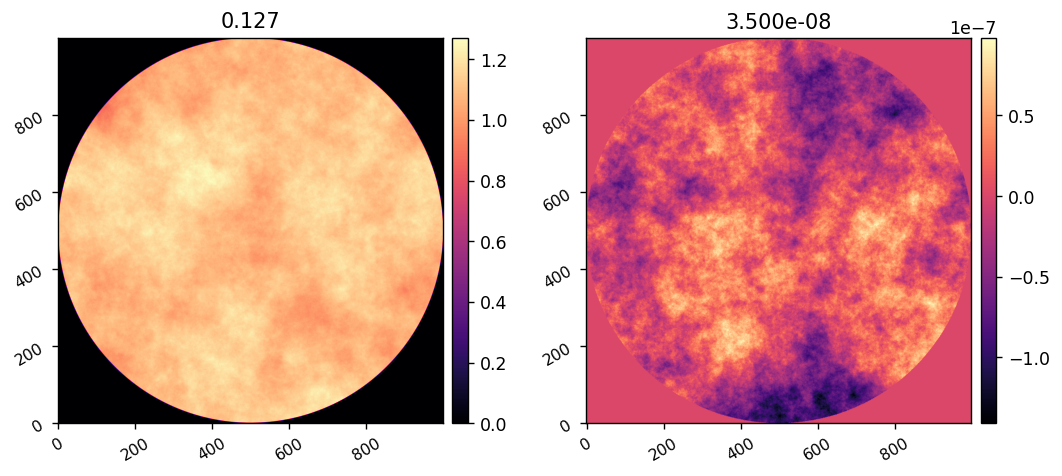

In [3]:

import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload

from matplotlib.patches import Circle

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob as scoob
import scoobpsf.dm as dm

import lina

npsf = 200

wavelength = 633*u.nm
pupil_diam = 6.75*u.mm

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')
lina.utils.rms(wfe_opd[mask])

scc_position = (15/2.5*u.mm, 0*u.mm)
scc_position = (5.5*u.mm/np.sqrt(2), 5.5*u.mm/np.sqrt(2))

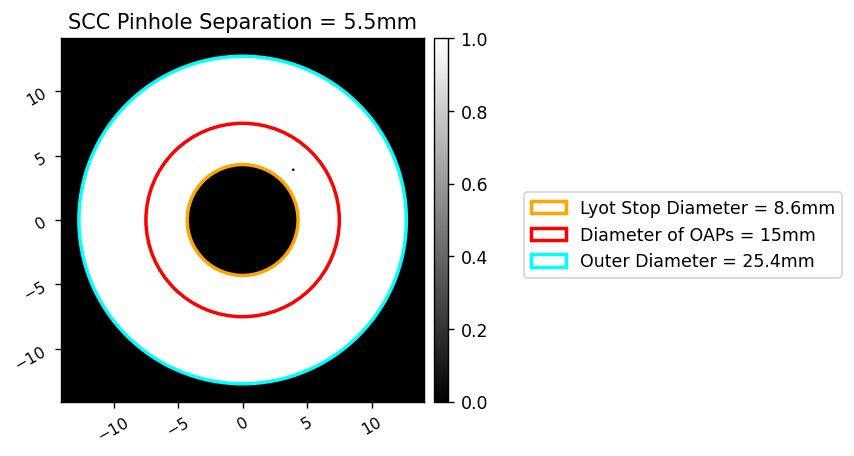

In [4]:
reload(scoob)
model = scoob.CORO(scc_pinhole_position=scc_position)
model.scc_diam = 200*u.um
# imshow1(model.LYOT)

# model.use_scc()
# imshow1(model.LYOT)

# model.use_scc(False)
# imshow1(model.LYOT)

model.use_llowfsc()
fig, ax = imshow1(model.LYOT, 'SCC Pinhole Separation = 5.5mm',
        npix=3000, pxscl=model.lyot_pupil_diam/model.npix, cmap='gray',
        patches=[Circle((0,0), 8.6/2, fill=False, linewidth=2, color='orange', label='Lyot Stop Diameter = 8.6mm'),
                    Circle((0,0), 15/2, fill=False, linewidth=2, color='red', label='Diameter of OAPs = 15mm'),
                    Circle((0,0), 25.4/2, fill=False, linewidth=2, color='cyan', label='Outer Diameter = 25.4mm'),], 
                 return_fig=True, display_fig=False)
ax.legend(bbox_to_anchor = [1.25, 0.6])
display(fig)
            

# model.use_llowfsc(False)
# imshow1(model.LYOT)

# model.use_scc()
# imshow1(model.LYOT)

# model.block_lyot()
# imshow1(model.LYOT)

# model.block_lyot(False)
# imshow1(model.LYOT)


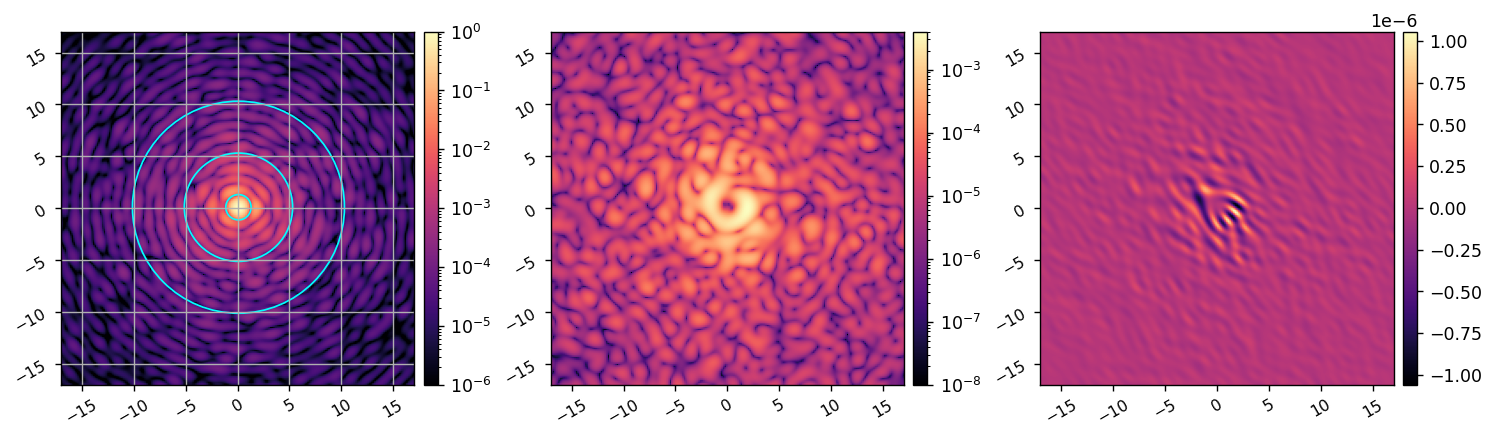

In [8]:
reload(scoob)
reload(scoobpsf.props)
model = scoob.CORO()
model.scc_diam = 50*u.um
model.scc_pinhole_position = scc_position

model.WFE = WFE
ref_psf = model.snap()
model.Imax_ref = xp.max(ref_psf)

model.use_fpm = True

ref_im = model.snap()

model.use_scc()
scc_im = model.snap()
model.use_scc(False)

imshow3(ref_psf/model.Imax_ref, ref_im, ref_im - scc_im, 
        lognorm1=True, lognorm2=True, vmin1=1e-6, vmin2=1e-8,
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+4, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+9, fill=False, color='cyan')])

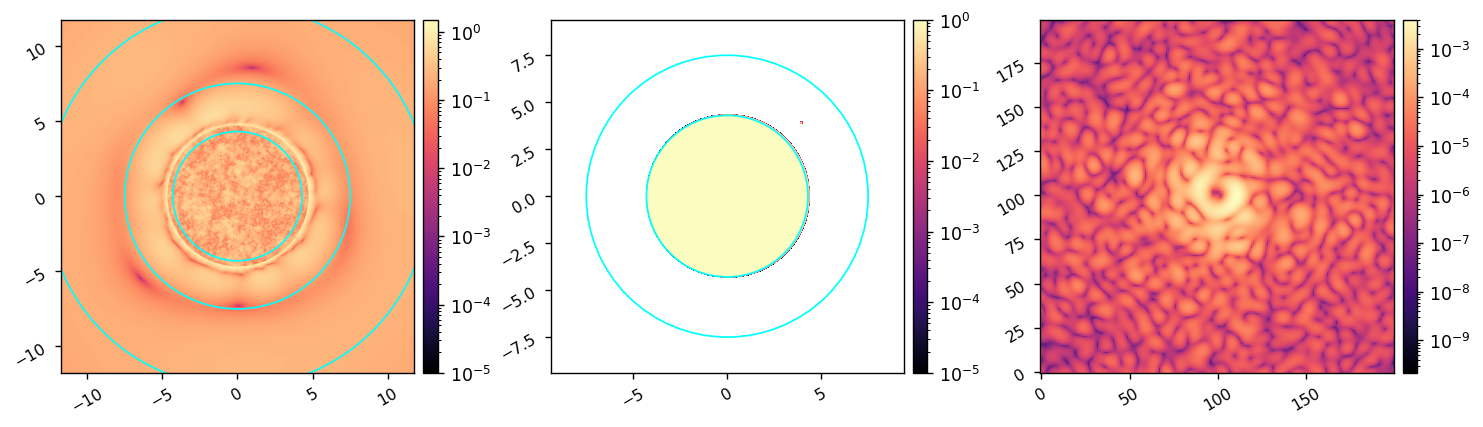

In [10]:
wfs = model.calc_wfs()

imshow3(xp.abs(wfs[-3]), xp.abs(wfs[-2])>1e-4, ref_im, 
        npix2=2*model.npix, 
        lognorm1=True, vmin1=1e-5, 
        lognorm2=True, vmin2=1e-5, 
        lognorm3=True,
        pxscl1=model.lyot_pupil_diam/model.npix, pxscl2=model.lyot_pupil_diam/model.npix,
        patches1=[Circle((0,0), 8.6/2, fill=False, color='cyan'),
                  Circle((0,0), 15/2, fill=False, color='cyan'),
                  Circle((0,0), 25.4/2, fill=False, color='cyan'),],
        patches2=[Circle((0,0), 8.6/2, fill=False, color='cyan'),
                  Circle((0,0), 15/2, fill=False, color='cyan'),],
                  )

# test standard SCC

In [11]:
def estimate_coherent(sysi, r_npix=0, shift=(0,0), dark_mask=None, plot=False, plot_est=False):
    '''
    r_npix:
        radius of sidebands in units of pixels
    shift:
        location of sideband centers in pixels (from center of array)
    '''

    im = sysi.snap()
    
    if dark_mask is not None:
        im *= dark_mask

    im_max = im.max()
    
    im_fft = xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(im), norm='ortho'))
    # im_fft_sum = xp.sum(xp.abs(im_fft))
    
    if plot:
        imshow2(xp.abs(im_fft), xp.angle(im_fft), lognorm1=True)
    im_fft_shift = _scipy.ndimage.shift(im_fft, shift)
    
    x = xp.linspace(-im.shape[0]//2, im.shape[0]//2-1, im.shape[0]) + 1/2
    x,y = xp.meshgrid(x,x)
    
    r = xp.sqrt(x**2 + y**2)
    mask = r<r_npix
    im_fft_masked = mask*im_fft_shift
    
    # im_fft_masked_sum = xp.sum(xp.abs(im_fft_masked))
    # im_fft_masked *= xp.sqrt((im_fft_sum-im_fft_masked_sum)/im_fft_masked_sum)
    
    if plot:
        fig,ax = imshow3(mask, xp.abs(im_fft_shift), xp.abs(im_fft_masked), lognorm2=True, lognorm3=True,
                         display_fig=False, return_fig=True)
        ax[1].grid()
        ax[1].set_xticks(np.linspace(0, im_fft_shift.shape[0], 7))
        ax[1].set_yticks(np.linspace(0, im_fft_shift.shape[0], 7))

        display(fig)
    
    E_est = xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(im_fft_masked), norm='ortho'))

    if dark_mask is not None:
        E_est *= dark_mask

    norm = (xp.abs(E_est) ** 2).max()
    E_est *= xp.sqrt(im_max / norm)

    if plot or plot_est:
        imshow2(xp.abs(E_est)**2, xp.angle(E_est), lognorm1=True, pxscl=sysi.psf_pixelscale_lamD)

    return E_est

    

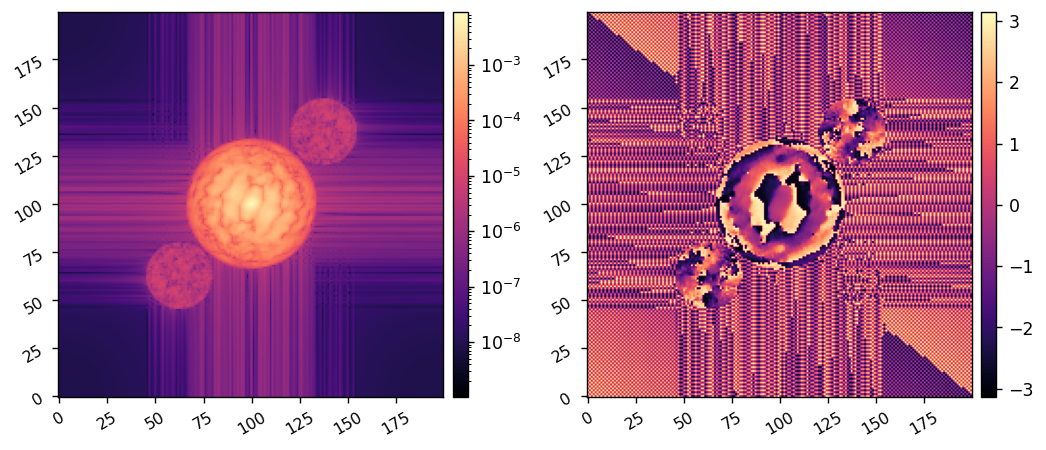

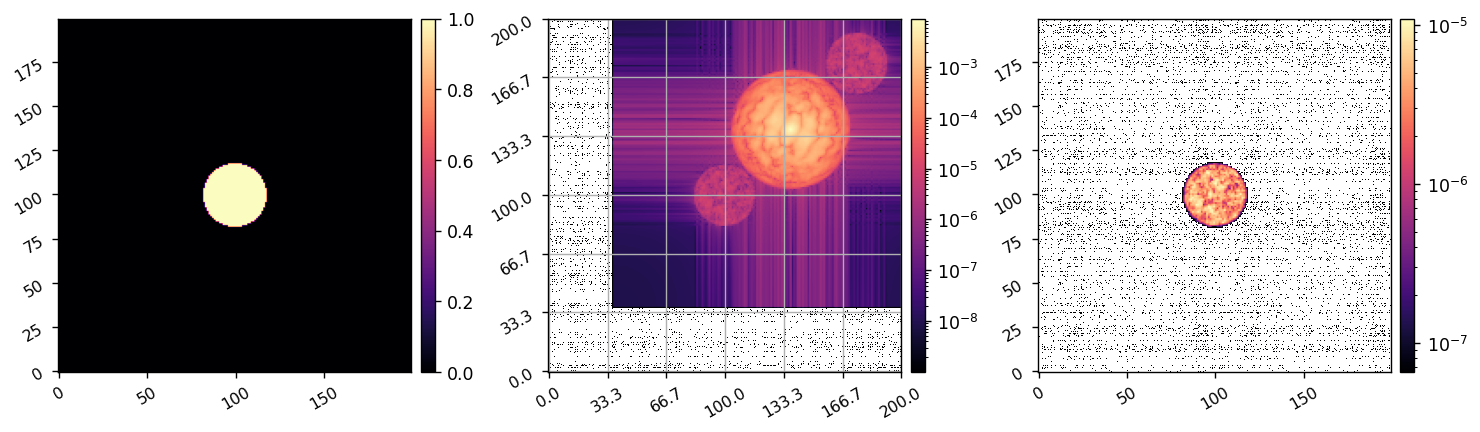

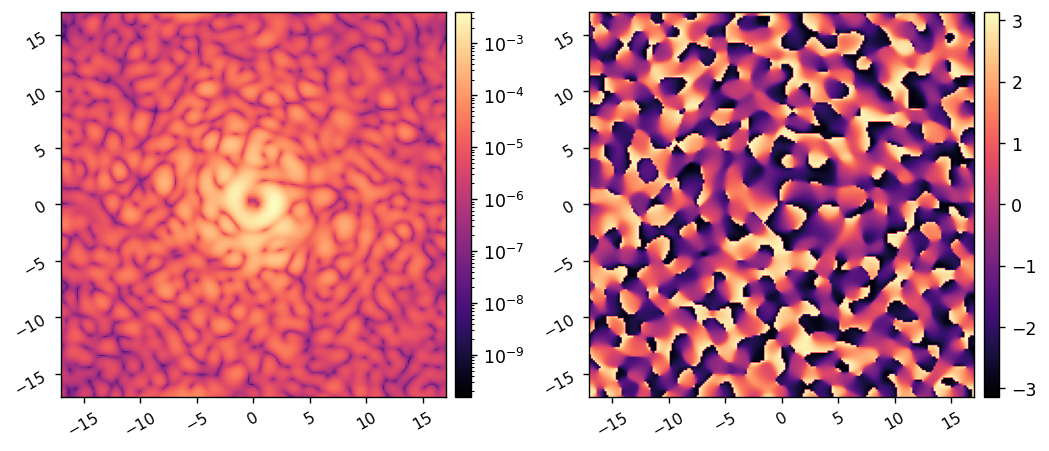

In [14]:
model.scc_pinhole_position = (1.55/np.sqrt(2) * 8.6*u.mm, 1.55/np.sqrt(2) * 8.6*u.mm)
model.scc_diam = 200*u.um
model.use_scc()
E_est = estimate_coherent(model, r_npix=18, shift=(37,37), plot=True)

# Test modulated SCC

# Without control mask

In [18]:
import lina

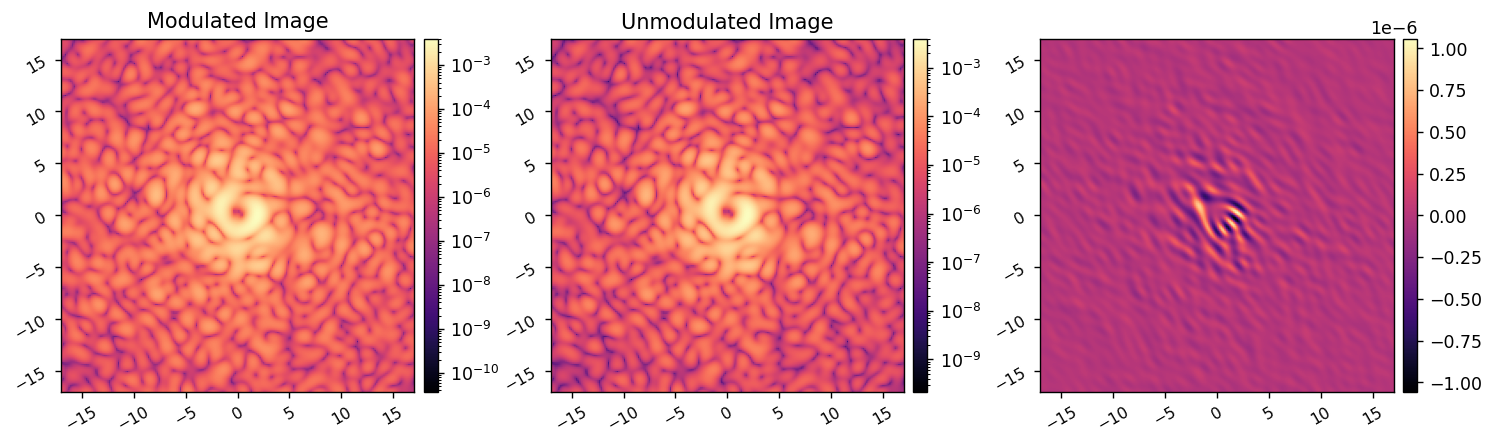

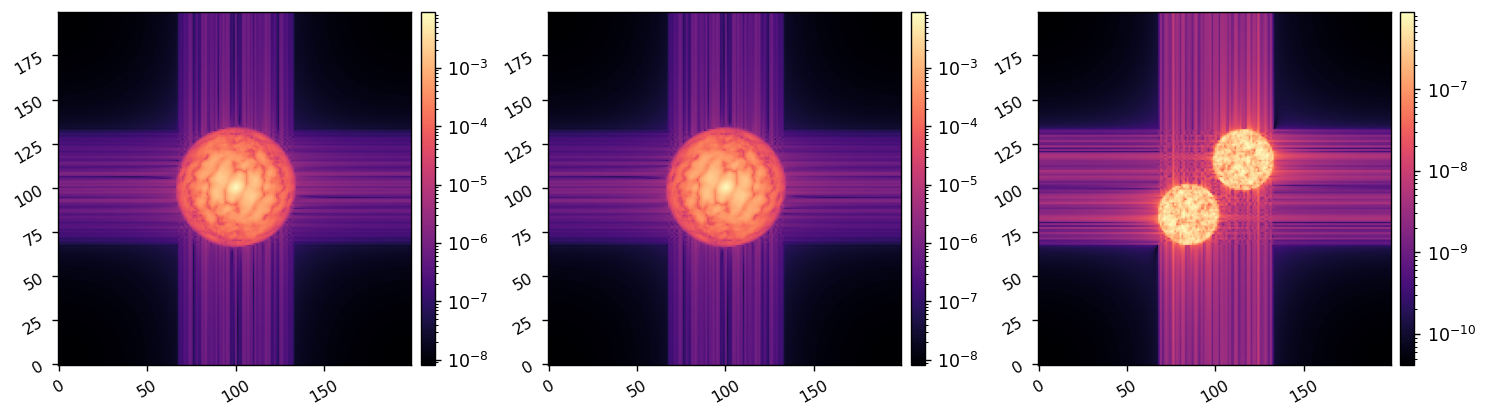

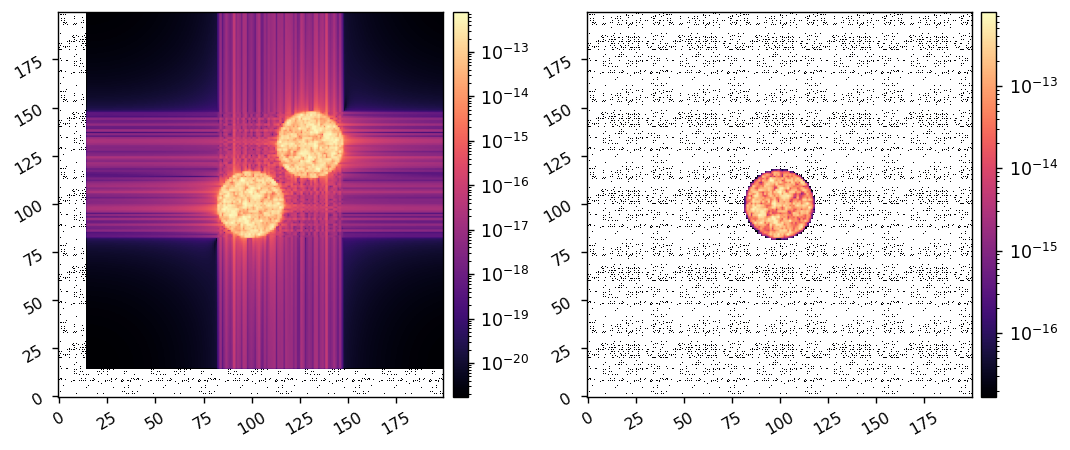

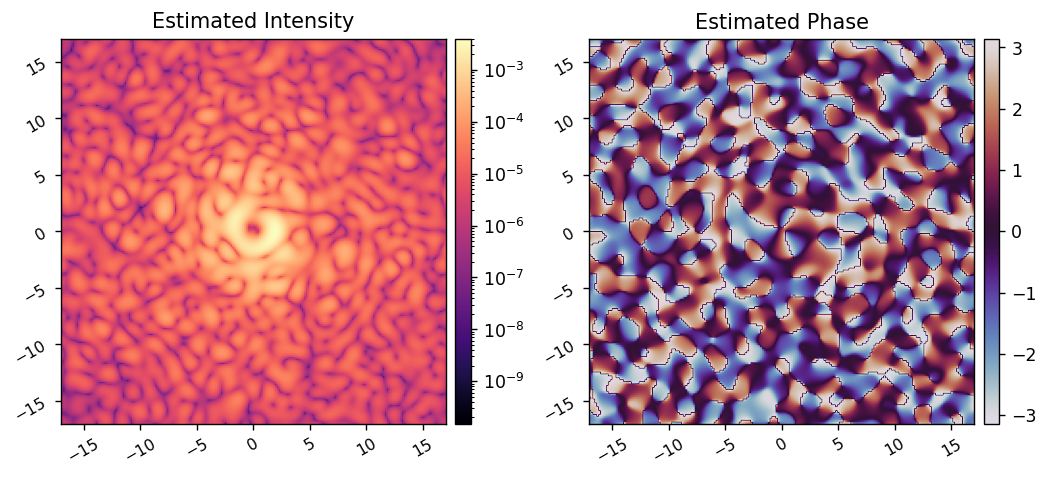

In [20]:

model.scc_diam = 50*u.um
model.scc_pinhole_position = scc_position
model.use_scc()

scc_params = {
    'r_npix':18, 
    'shift':(15,15), 
    # 'scc_ref_image':scc_ref_image,
    # 'dark_mask':control_mask,
    'plot':True,
}

E_est = lina.scc.estimate_coherent_mod(model, **scc_params)
                                    

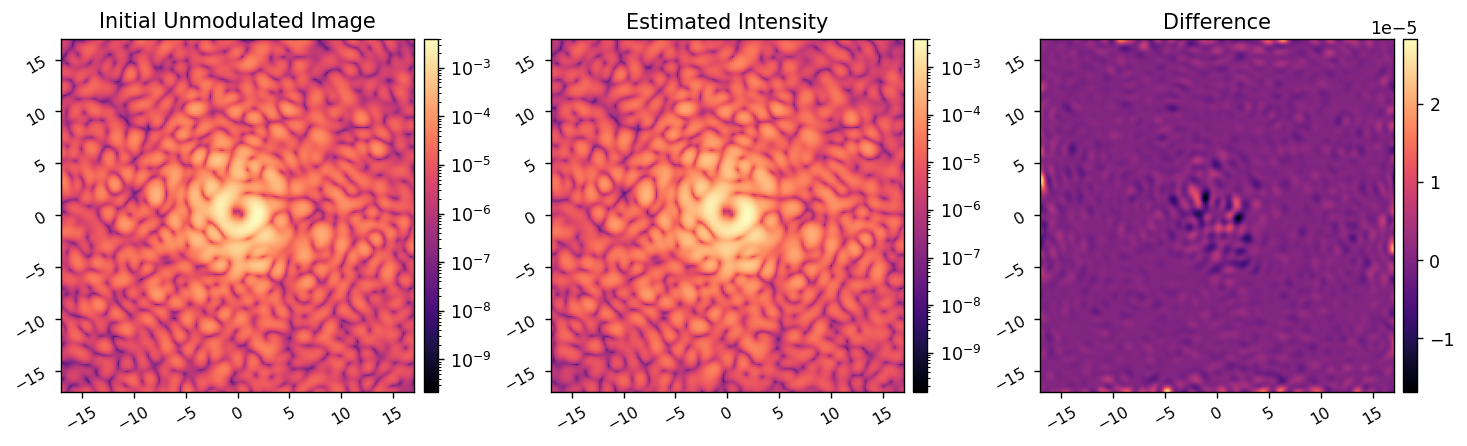

In [22]:
imshow3(ref_im, xp.abs(E_est)**2, ref_im -  xp.abs(E_est)**2, 
        'Initial Unmodulated Image', 'Estimated Intensity', 'Difference',
        lognorm1=True, lognorm2=True, pxscl=model.psf_pixelscale_lamD)

# With control mask

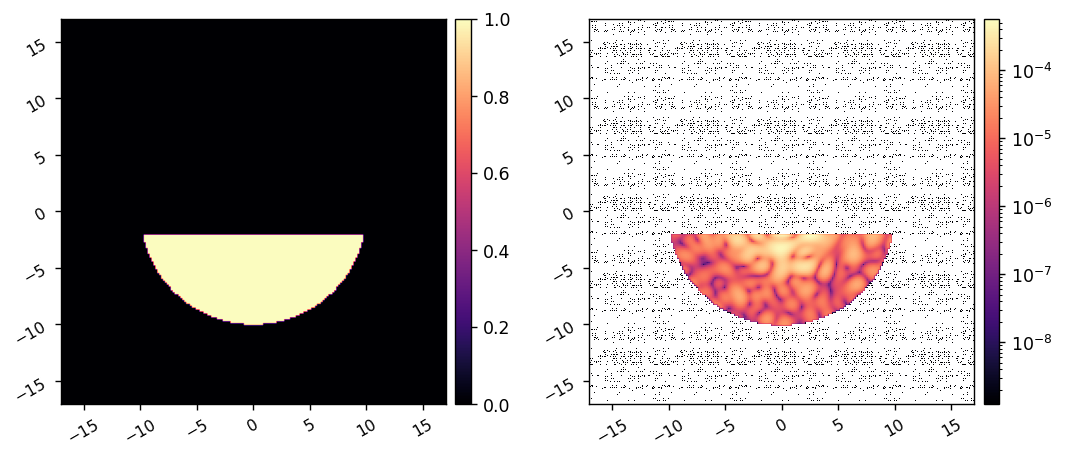

In [91]:
reload(lina.utils)
control_mask = lina.utils.create_annular_focal_plane_mask(model, 2, 10, 2, rotation=90)
imshow2(control_mask, unmod_im*control_mask, lognorm2=True, pxscl=model.psf_pixelscale_lamD)

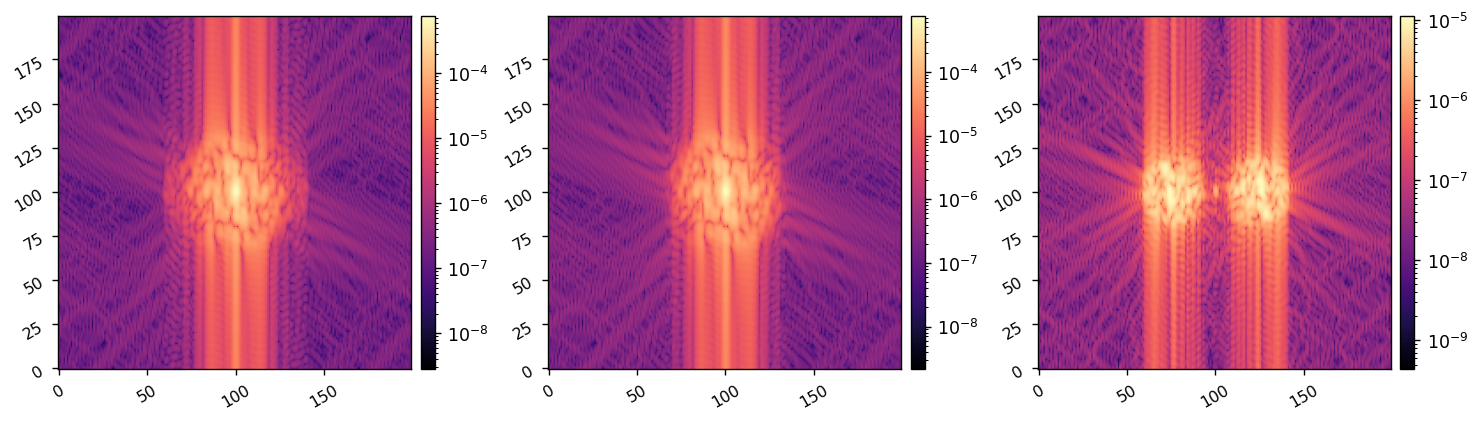

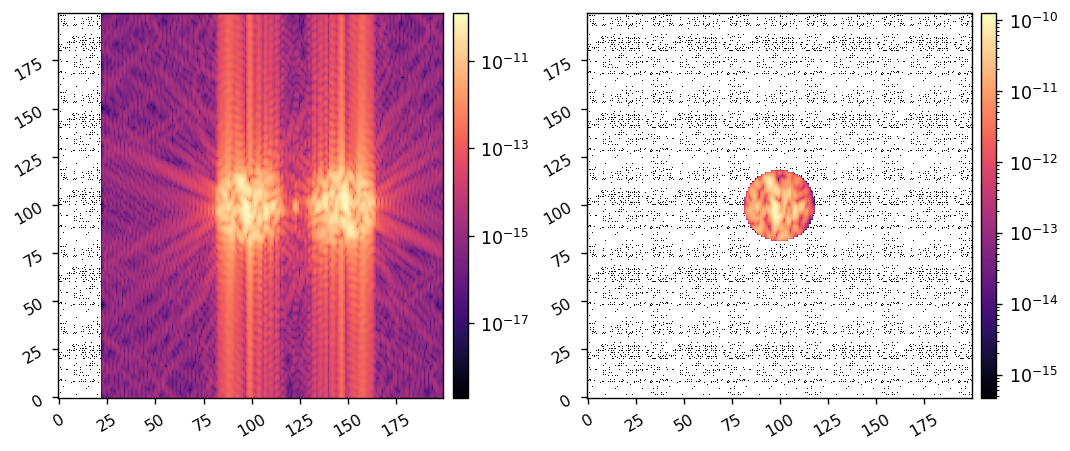

In [92]:
E_est = estimate_coherent_mod(mod_image=mod_im, unmod_image=unmod_im, scc_ref_image=scc_ref_im,
                                    dark_mask=control_mask, 
                                    r_npix=18, 
                                    shift=(-1,23), 
                                    plot=True,
                                    )

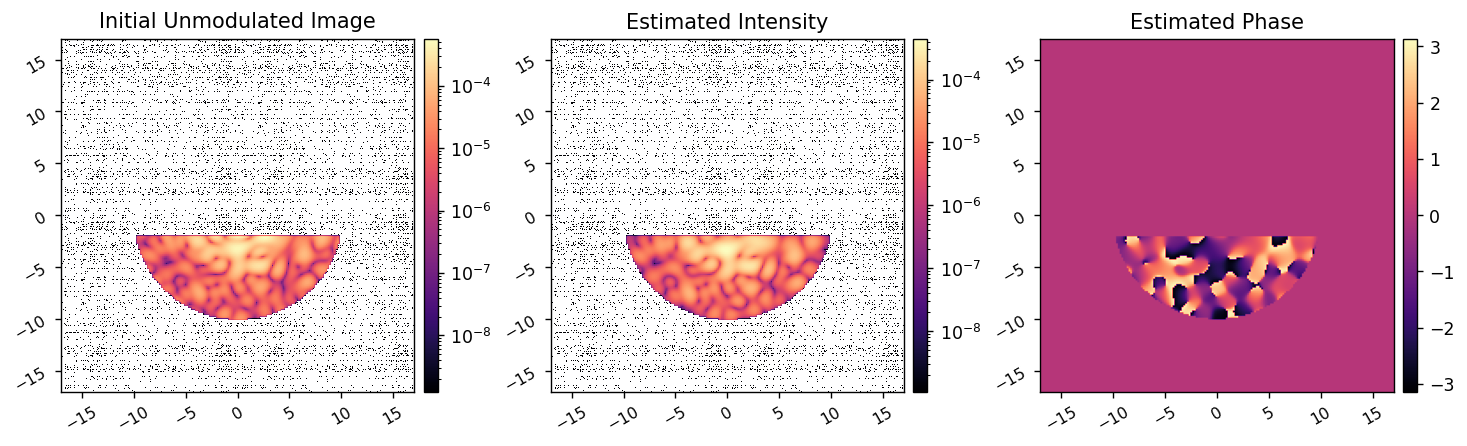

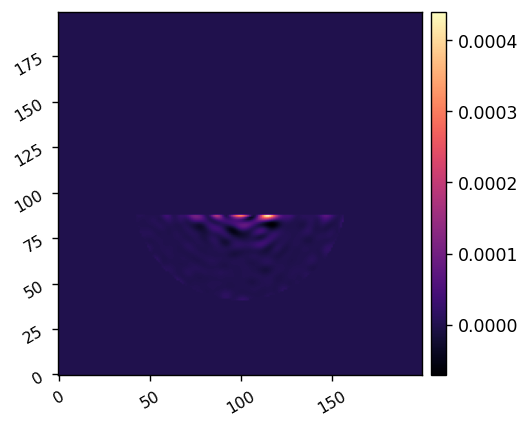

In [93]:
imshow3(control_mask*unmod_im, xp.abs(E_est)**2, xp.angle(E_est), 
        'Initial Unmodulated Image', 'Estimated Intensity', 'Estimated Phase',
        lognorm1=True, lognorm2=True, pxscl=model.psf_pixelscale_lamD)

diff = unmod_im - xp.abs(E_est)**2
imshow1(diff)